In [29]:
import numpy as np

img_embed = np.load("anger_resnet50_image_embeddings.npz")

img_embed.files
img_embed['arr_3011'].shape

(2048,)

In [30]:
word_embed = np.load("bert_word_embeddings.npz")

word_embed.files
word_embed['arr_3011'].shape

(768,)

In [31]:
np.concatenate((word_embed['arr_0'], img_embed['arr_0']), axis=None).shape

(2816,)

In [32]:
data = []

from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, FeatureUnion

for i in range(0, 3012):
    key_str = 'arr_' + str(i)
    data.append(np.concatenate((word_embed[key_str], img_embed[key_str]), axis=None))

In [33]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
import time
import pandas as pd
import seaborn as sn
import keras
import os
import cv2
import pickle
import random
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib
# matplotlib.use("Agg")

In [34]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 300
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (224, 224, 3)

In [35]:
from keras.preprocessing.image import img_to_array
import pandas as pd
import numpy as np


labels = []

df_items = pd.read_csv('items-Copy1.csv') # read dataset into pandas dataframe

# replace field that's entirely space (or empty) with NaN
df_items = df_items.replace(np.nan, '', regex=True)

# binary classification so either anger or not
for i, row in df_items.iterrows():
    row['tag'] = row['tag'].lower() # convert tags to lowercase
    if 'anger' in row['tag']:
        labels.append('anger')
    else:
        labels.append('non_anger')

In [36]:
labels = np.array(labels)

In [37]:
from sklearn.preprocessing import LabelBinarizer

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [38]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

In [39]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential([
    Dense(1024, activation='relu', input_shape=(2816,)),
    Dense(512, activation='relu'),
    Dense(1,activation='sigmoid')
])
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer='adam',
    metrics=["accuracy"])
print("[INFO] done compiling.")

model.summary()


[INFO] done compiling.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              2884608   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 3,409,921
Trainable params: 3,409,921
Non-trainable params: 0
_________________________________________________________________


In [40]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(trainX)
rescaledX_test = scaler.fit_transform(testX)

In [ ]:
# train the network
print("[INFO] training network...")
# H = model.fit_generator(
#     aug.flow(trainX, trainY, batch_size=BS),
#     validation_data=(testX, testY),
#     steps_per_epoch=len(trainX) // BS,
#     epochs=EPOCHS, verbose=1)#, class_weight={0:3, 1:1})
model.fit(np.array(rescaledX_train), np.array(trainY), epochs=100, batch_size=64, validation_split=0.2)
# save the model to disk
print("[INFO] serializing network...")
model.save("anger_imbalanced_fusion_embeddings_fully_connected.model")

[INFO] training network...
Train on 2288 samples, validate on 121 samples
Epoch 1/100
2288/2288 [==============================] - 0s 61us/step - loss: 0.3347 - accuracy: 0.9008 - val_loss: 0.3326 - val_accuracy: 0.8264
Epoch 2/100
2288/2288 [==============================] - 0s 60us/step - loss: 0.2795 - accuracy: 0.8671 - val_loss: 0.2245 - val_accuracy: 0.9008
Epoch 3/100
2288/2288 [==============================] - 0s 60us/step - loss: 0.1984 - accuracy: 0.9104 - val_loss: 0.1607 - val_accuracy: 0.9174
Epoch 4/100
2288/2288 [==============================] - 0s 62us/step - loss: 0.1504 - accuracy: 0.9353 - val_loss: 0.1459 - val_accuracy: 0.9421
Epoch 5/100
2288/2288 [==============================] - 0s 61us/step - loss: 0.1189 - accuracy: 0.9489 - val_loss: 0.1229 - val_accuracy: 0.9339
Epoch 6/100
2288/2288 [==============================] - 0s 61us/step - loss: 0.1065 - accuracy: 0.9563 - val_loss: 0.2265 - val_accuracy: 0.9008
Epoch 7/100
2288/2288 [===========================

2288/2288 [==============================] - 0s 61us/step - loss: 0.0165 - accuracy: 0.9952 - val_loss: 0.3169 - val_accuracy: 0.8843
Epoch 57/100
2288/2288 [==============================] - 0s 59us/step - loss: 0.0136 - accuracy: 0.9965 - val_loss: 0.2772 - val_accuracy: 0.9091
Epoch 58/100
2288/2288 [==============================] - 0s 60us/step - loss: 0.0134 - accuracy: 0.9974 - val_loss: 0.2719 - val_accuracy: 0.9091
Epoch 59/100
2288/2288 [==============================] - 0s 61us/step - loss: 0.0216 - accuracy: 0.9926 - val_loss: 0.2925 - val_accuracy: 0.9091
Epoch 60/100
2288/2288 [==============================] - 0s 59us/step - loss: 0.0198 - accuracy: 0.9926 - val_loss: 0.2802 - val_accuracy: 0.9008
Epoch 61/100
2288/2288 [==============================] - 0s 60us/step - loss: 0.0190 - accuracy: 0.9939 - val_loss: 0.4991 - val_accuracy: 0.8760
Epoch 62/100
2288/2288 [==============================] - 0s 60us/step - loss: 0.0141 - accuracy: 0.9965 - val_loss: 0.3207 - val_a

In [46]:
yhat_probs = model.predict(np.array(rescaledX_test), verbose=0)

In [47]:
yhat_classes = np.argmax(yhat_probs, axis=1)

Classification report: 
---------------------------------------------------------- 
              precision    recall  f1-score   support

       anger       0.27      1.00      0.43       165
   non-anger       0.00      0.00      0.00       438

    accuracy                           0.27       603
   macro avg       0.14      0.50      0.21       603
weighted avg       0.07      0.27      0.12       603

---------------------------------------------------------- 
Accuracy score: 0.273632
Precision score: 0.000000
Recall score: 0.000000
F1 score: 0.000000
---------------------------------------------------------- 
Confusion matrix: 
[[165   0]
 [438   0]]


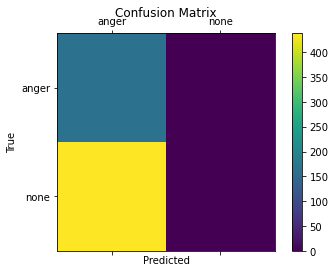

[[165   0]
 [438   0]]


In [48]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

classif_report = classification_report(testY, yhat_classes, target_names=['anger', 'non-anger'])
print('Classification report: ')
print('---------------------------------------------------------- ')
print(classif_report)

print('---------------------------------------------------------- ')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy score: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision score: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall score: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
print('---------------------------------------------------------- ')

# confusion matrix
labels = ['anger', 'none']
matrix = confusion_matrix(testY, yhat_classes)
print('Confusion matrix: ')
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_anger_minority_duplicated_resnet50_400_epochs.png')
plt.show()
print(matrix)